<ipython-input-9-2ad3128ad672>:8: RuntimeWarning: invalid value encountered in sqrt
  dr -= sigma * np.sqrt(r) * np.sqrt(dt) * np.random.normal()


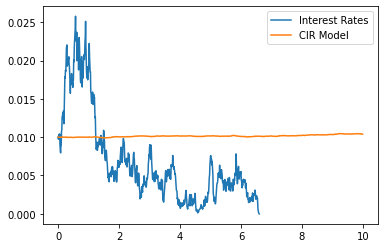

Estimated Parameters:
a: 0.1
b: 0.05
Kappa: 0.1
Theta: 2.0
Volatility: 0.7071067811865476


In [9]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# Define the CIR model
def cir_model(r, a, b, sigma, dt):
    dr = a * (b - r) * dt
    dr -= sigma * np.sqrt(r) * np.sqrt(dt) * np.random.normal()
    return dr

# Define the integrated process
def integrated_process(r, dt):
    y = np.cumsum(r)[:-1] * dt
    return y

# Define the exponential integrated process
def exp_integrated_process(y, a, b, dt):
    z = np.exp(-a * np.arange(len(y)) * dt) * (y - a / b * dt)
    return z

# Define the function to minimize
def minimize_func(param, r, dt):
    a, b, sigma = param
    y = integrated_process(r, dt)
    z = exp_integrated_process(y, a, b, dt)
    z_shift = np.concatenate(([z[0]], z[:-1]))
    diff = z - z_shift * np.exp(-a * dt)
    obj_func = np.mean(diff ** 2)
    return obj_func

# Set the initial parameters
a = 0.1
b = 0.05
sigma = 0.1

# Simulate the interest rate data using the CIR model
dt = 0.01
t = np.arange(0, 10, dt)
r = np.zeros(len(t))
r[0] = 0.01
for i in range(len(t) - 1):
    dr = cir_model(r[i], a, b, sigma, dt)
    r[i + 1] = r[i] + dr

# Estimate the CIR model parameters using the martingale approach
param_init = [0.1, 0.05, 0.1]
result = optimize.minimize(minimize_func, param_init, args=(r, dt), method='Nelder-Mead')
a, b, sigma = result.x

# Calculate the CIR model parameters
kappa = a
theta = a / b
volatility = np.sqrt(kappa / (2 * a))

# Plot the estimated CIR model and the interest rate data
plt.plot(t, r, label='Interest Rates')
t_cir = np.arange(0, 10, 0.01)
r_cir = np.zeros(len(t_cir))
r_cir[0] = r[0]
for i in range(len(t_cir) - 1):
    dr_cir = cir_model(r_cir[i], a, b, sigma, 0.01)
    r_cir[i + 1] = r_cir[i] + dr_cir * 0.01
plt.plot(t_cir, r_cir, label='CIR Model')
plt.legend()
plt.savefig('cir_model.png')
plt.show()

print('Estimated Parameters:')
print('a:', a)
print('b:', b)
print('Kappa:', kappa)
print('Theta:', theta)
print('Volatility:', volatility)


In [ ]:
from dataclasses import dataclass
from typing import Optional, NoReturn, Any, Union

import numpy as np
from sklearn.linear_model import LinearRegression

#import brownian_motion
cir_params = CIRParams(a=1.5, b=0.05, c=0.05)

# ----------------------------------------------------------------
# CIR process


@dataclass
class CIRParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float  # Brownian motion scale factor (standard deviation)

    def __post_init__(self) -> Optional[NoReturn]:
        if 2 * self.a * self.b < self.c ** 2:
            raise ValueError("2ab has to be less than or equal to c^2.")
        return None


def get_CIR_process(
    T: int,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    dW = brownian_motion.get_dW(T, random_state)
    return _generate_CIR_process(dW, CIR_params, sigma_0)


def _generate_CIR_process(
    dW: np.ndarray,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the CIR process given the Brownian motion.
    - dW is a 1D array with the Brownian motion increments.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    T = len(dW)
    _sigma_0 = _select_sigma_0(sigma_0, CIR_params)
    sigma_t = [_sigma_0]
    for t in range(1, T):
        dsigma_t = (
            CIR_params.a * (CIR_params.b - sigma_t[t - 1])
            + CIR_params.c * np.sqrt(sigma_t[t - 1]) * dW[t]
        )
        # if Nan in simulation raise an error.
        _validate_not_nan(dsigma_t)
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], CIR_params: CIRParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return CIR_params.b


def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
    if np.isnan(dsigma_t):
        raise ValueError(
            "CIR process simulation crashed, check your CIR_params. "
            + "Maybe choose a smaller c value."
        )
    return None


# ----------------------------------------------------------------
# CIR parameters from data with OLS.


def estimate_CIR_params(sigma_t: np.ndarray) -> CIRParams:
    """
    Estimate CIR params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return CIRParams(a, b, c)


# ---------------------------------------------------------------
# Correlated OU processes


def get_corr_CIR_procs(
    T: int,
    CIR_params: Union[CIRParams, tuple[CIRParams, ...]],
    n_procs: Optional[int] = None,
    rho: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    Simulate correlated CIR processes, correlation (rho) can be 0 or None.
    - T is the sample size of the processes.
    - CIR_params can be a an instance of CIRParams, in that case
        all processes have the same parameters. It can also be a tuple,
        in that case each process will have the parameters in the tuple,
        each column in the resulting 2D array corresponds to the tuple index.
    - n_procs is ignored if CIR_params is tuple, else, corresponds to the number
        of processes desired. If CIR_params is not tuple and n_procs is None, will
        raise ValueError.
    - rho is the correlation coefficient.
    - random_state to reproduce results.
    """
    _n_procs = _get_n_procs(CIR_params, n_procs)
    corr_dWs = brownian_motion.get_corr_dW_matrix(
        T, _n_procs, rho, random_state=random_state
    )
    is_CIR_params_tpl = _is_CIR_params_tuple(CIR_params)
    CIR_procs = []
    for i in range(_n_procs):
        CIR_params_i = _get_CIR_params_i(CIR_params, i, is_CIR_params_tpl)
        dW_i = corr_dWs[:, i]
        CIR_procs.append(_get_CIR_process_i(CIR_params_i, dW_i))
    return np.asarray(CIR_procs).T


def _is_CIR_params_tuple(
    CIR_params: Union[CIRParams, tuple[CIRParams, ...]]
) -> bool:
    """
    Check is CIR_params is a tuple of params,
    return bool.
    """
    return isinstance(CIR_params, tuple)


def _get_n_procs(
    CIR_params: Union[CIRParams, tuple[CIRParams, ...]], n_procs: Optional[int]
) -> int:
    """
    Define the number of processes, if CIR_params is a tuple the
    number of processes is the lenght of the tuple. If it is not a tuple
    then it is the "n_procs" supplied as argument,
    if it is None will raise ValueError.
    """
    if _is_CIR_params_tuple(CIR_params):
        return len(CIR_params)  # type: ignore
    elif n_procs is None:
        raise ValueError("If OU_params is not tuple, n_procs cannot be None.")
    return n_procs


def _get_CIR_params_i(
    CIR_params: Union[CIRParams, tuple[CIRParams, ...]],
    i: int,
    is_CIR_params_tpl: bool,
) -> CIRParams:
    """
    Returns the ith value of the CIR_params tuple if it is a tuple,
    otherwise returns CIRParams.
    """
    if is_CIR_params_tpl:
        return CIR_params[i]  # type: ignore
    return CIR_params  # type: ignore


def _get_CIR_process_i(CIR_params: CIRParams, dW: np.ndarray) -> np.ndarray:
    """
    Simulates the CIR process with an external dW.
    sigma_0 is taken as the asymptotic mean b for simplicity.
    """
    return _generate_CIR_process(dW, CIR_params)